In [1]:
import toml
from importlib import reload
from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from gwpy.timeseries import TimeSeries, TimeSeriesDict
from hermes.quiver.streaming.streaming_input import Snapshotter
from hermes.quiver.streaming.streaming_output import OnlineAverager

from deepclean.architectures import DeepCleanAE
from deepclean.export.model import DeepClean
from deepclean.infer import callback
from deepclean.logging import logger

from microservice.deployment import Deployment
from microservice.frames import get_channels
from ml4gw.transforms import ChannelWiseScaler
from trainer.main import train_on_segment


home = Path.home()
run_dir = home / "deepclean" / "results" / "microservice" / "sandbox-live"
ifo = "L1"
device = "cuda:1"

deployment = Deployment(run_dir)
log_file = deployment.log_directory / "run.log"
logger = logger.set_logger("Deepclean sandbox", log_file)

ifo = "L1"
with open("../pyproject.toml", "r") as f:
    config = toml.load(f)["tool"]["typeo"]

channels = config["base"]["channels"][ifo]
channels = get_channels(channels)
sample_rate = config["base"]["sample_rate"]

In [11]:
def download_data(start, duration, channels, cache_file):
    train_data = TimeSeriesDict.fetch(
        start=start,
        end=start + duration,
        channels=channels
    )
    train_data = train_data.resample(sample_rate)
    X = np.stack([train_data.pop(i).value for i in channels[1:]])
    y = train_data.pop(channels[0]).value

    with h5py.File(cache_file, "a") as f:
        group = f.create_group(ifo)
        group["X"] = X
        group["y"] = y
    return X, y


def get_data(cache_file, start, duration, channels):
    if cache_file.exists():
        with h5py.File(cache_file, "r") as f:
            if ifo in f:
                group = f[ifo]
                X = group["X"][:]
                y = group["y"][:]
            else:
                X, y = download_data(
                    start,
                    duration,
                    channels,
                    cache_file
                )
    else:
        X, y = download_data(
            start,
            duration,
            channels,
            cache_file
        )
    return X, y


def get_live_data(duration, channels, start=None):
    fnames = sorted((run_dir / "live-data" / "lldetchar" / ifo).iterdir())
    t0 = int(fnames[0].stem.split("-")[-2])
    if start is not None:
        t0 += start

    logger.info("Loading live data from span {}-{}".format(
        t0, t0 + duration
    ))
    ts = TimeSeriesDict.read(
        fnames,
        start=t0,
        end=t0 + duration,
        channels=channels[1:]
    )
    ts = ts.resample(sample_rate)
    X = np.stack([ts.pop(i).value for i in channels[1:]])
    logger.info("Witness channels loaded")

    fnames = sorted((run_dir / "live-data" / "kafka" / ifo).iterdir())
    ts = TimeSeries.read(
        fnames,
        start=t0,
        end=t0 + duration,
        channel=channels[0]
    )
    y = ts.resample(sample_rate).value
    logger.info("Strain data loaded")
    return t0, X, y


def train(duration, start=None):  # cache_file):
    # X, y = get_data(
    #     cache_file,
    #     start,
    #     duration,
    #     channels
    # )
    t0, X, y = get_live_data(duration, channels, start=start)
    weights_path = train_on_segment(
        X,
        y,
        deployment,
        start=t0,
        architecture=DeepCleanAE,
        sample_rate=sample_rate,
        valid_frac=0.25,
        kernel_length=8,
        kernel_stride=1/16,
        freq_low=58,
        freq_high=62,
        batch_size=256,
        max_epochs=50,
        device=device
    )
    return weights_path


In [12]:
cache_file = deployment.storage_directory / "train.h5"
train_start = 1243278913
train_duration = 4096

train_stop = train_start + train_duration
train_dir = deployment.train_directory / f"{train_start}-{train_stop}"
weights_path = train_dir / "weights.pt"
if not weights_path.exists():
    weights_path = train(train_duration, None) #, cache_file)
else:
    logger.info(f"Loading weights from {weights_path}")

preprocessor = ChannelWiseScaler(len(channels) - 1)
postprocessor = ChannelWiseScaler()
nn = DeepCleanAE(len(channels) - 1)
deepclean = DeepClean(preprocessor, nn, postprocessor)
deepclean.load_state_dict(torch.load(weights_path))
deepclean = deepclean.to(device)
deepclean.eval()

2023-06-12 20:50:04,309 - Deepclean sandbox - INFO - Loading live data from span 1370643654-1370647750
2023-06-12 20:51:35,518 - Deepclean sandbox - INFO - Witness channels loaded
2023-06-12 20:52:04,316 - Deepclean sandbox - INFO - Strain data loaded
2023-06-12 20:52:04,345 - Deepclean sandbox - INFO - Saving training outputs to directory /home/alec.gunny/deepclean/results/microservice/sandbox-live/train/1370643654-1370647750
2023-06-12 20:52:53,435 - DeepClean train 1370643654-1370647750 - INFO - Building and initializing model
2023-06-12 20:52:53,444 - DeepClean train 1370643654-1370647750 - INFO - DeepCleanAE(
  (input_conv): ConvBlock(
    (conv): Conv1d(18, 18, kernel_size=(7,), stride=(1,), padding=(3,))
    (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ELU(alpha=1.0)
  )
  (downsampler): Sequential(
    (CONV_1): ConvBlock(
      (conv): Conv1d(18, 8, kernel_size=(7,), stride=(2,), padding=(3,))
      (bn): BatchNorm1d(8

DeepClean(
  (preprocessor): Preprocessor(
    (scaler): ChannelWiseScaler()
  )
  (deepclean): DeepCleanAE(
    (input_conv): ConvBlock(
      (conv): Conv1d(18, 18, kernel_size=(7,), stride=(1,), padding=(3,))
      (bn): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ELU(alpha=1.0)
    )
    (downsampler): Sequential(
      (CONV_1): ConvBlock(
        (conv): Conv1d(18, 8, kernel_size=(7,), stride=(2,), padding=(3,))
        (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ELU(alpha=1.0)
      )
      (CONV_2): ConvBlock(
        (conv): Conv1d(8, 16, kernel_size=(7,), stride=(2,), padding=(3,))
        (bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ELU(alpha=1.0)
      )
      (CONV_3): ConvBlock(
        (conv): Conv1d(16, 32, kernel_size=(7,), stride=(2,), padding=(3,))
        (bn): BatchNorm1d(32, eps=1e-05,

# Export
Set up the input and output caching models to use locally

In [13]:
infer_batch_size = 256
inference_sampling_rate = 512
stride = int(sample_rate / inference_sampling_rate)
aggregation_size = int(0.5 * sample_rate)
num_updates = int(aggregation_size // stride)

snapshotter = Snapshotter(
    snapshot_size=sample_rate,
    stride_size=stride,
    batch_size=infer_batch_size,
    channels_per_snapshot=[len(channels) - 1]
).to(device)

aggregator = OnlineAverager(
    update_size=stride,
    batch_size=infer_batch_size,
    num_updates=num_updates
).to(device)

# Inference
## Build dataset
Start by creating a small offline dataset of the test frames

In [14]:
test_start = train_start + train_duration
test_duration = 128
t0, X, y = get_live_data(test_duration, channels, start=train_duration)

2023-06-12 21:29:10,554 - Deepclean sandbox - INFO - Loading live data from span 1370647750-1370647878
2023-06-12 21:29:14,368 - Deepclean sandbox - INFO - Witness channels loaded
2023-06-12 21:29:18,418 - Deepclean sandbox - INFO - Strain data loaded


## Fully offline inference
First test: run through the offline data and postprocess it in an offline fashion

In [72]:
def do_inference(data_it):
    input_snapshot = torch.zeros((1, len(channels) - 1, sample_rate))
    input_snapshot = input_snapshot.to(device)
    snapshot_size = stride * (num_updates + infer_batch_size - 1)
    output_snapshot = torch.zeros((snapshot_size,)).to(device)

    for x in data_it:
        with torch.no_grad():
            x = torch.Tensor(x).to(device)
            x, input_snapshot = snapshotter(x[None], input_snapshot)
            y_hat = deepclean(x)
            y_hat, output_snapshot = aggregator(y_hat, output_snapshot)
            yield y_hat.cpu().numpy()

In [73]:
def offline_it():
    step_size = int(stride * infer_batch_size)
    num_steps = (X.shape[-1] - sample_rate) // step_size + 1
    for i in range(num_steps):
        start = i * step_size
        stop = (i + 1) * step_size
        yield X[:, start: stop]


def get_state():
    cb = reload(callback)
    return cb.State(
        "noise",
        frame_length=1,
        memory=8,
        filter_pad=1,
        sample_rate=sample_rate,
        inference_sampling_rate=inference_sampling_rate,
        batch_size=infer_batch_size,
        aggregation_steps=num_updates - 1,
        freq_low=58,
        freq_high=62,
    )

In [74]:
state = get_state()
predictions = []
for y_hat in do_inference(offline_it()):
    y_hat = y_hat[0]
    if not predictions:
        y_hat = y_hat[(num_updates - 1) * stride:]
    predictions.append(y_hat)
predictions = np.concatenate(predictions)
predictions = state.cleaner.bandpass(predictions)
clean = y[:len(predictions)] - predictions

Now let's build some plotting utilities to ensure that we've cleaned appropriately.

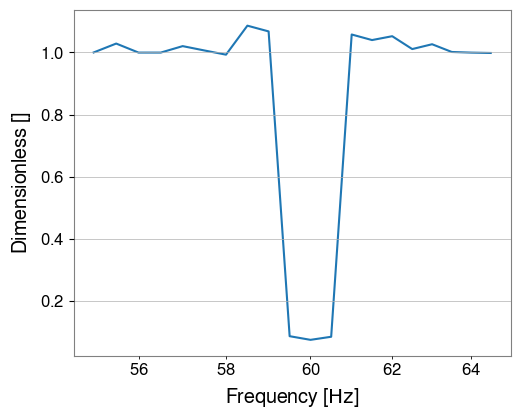

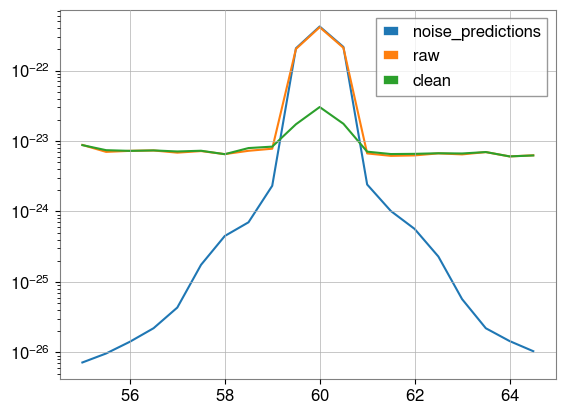

In [75]:
def plot_predictions(clean, raw, start=55, stop=65):
    raw = raw[:len(clean)]
    raw = TimeSeries(raw, sample_rate=sample_rate)
    clean = TimeSeries(clean, sample_rate=sample_rate)

    raw_asd = raw.asd(fftlength=2, method="median", window="hann")
    clean_asd = clean.asd(fftlength=2, method="median", window="hann")
    raw_asd = raw_asd.crop(start, stop)
    clean_asd = clean_asd.crop(start, stop)
    ratio = clean_asd / raw_asd
    ratio.plot()
    plt.show()


def plot_timeseries(start=55, stop=65, **timeseries):
    for label, ts in timeseries.items():
        ts = TimeSeries(ts, sample_rate=sample_rate)
        asd = ts.asd(fftlength=2, method="median", window="hann")
        plt.plot(asd.crop(start, stop), label=label)
    plt.legend()
    plt.yscale("log")
    plt.show()


plot_predictions(clean, y)
plot_timeseries(
    noise_predictions=predictions,
    raw=y,
    clean=clean
)

## Offline loading, online predictions, offline clean
Ok, now let's load data offline, but build noise predictions online before doing cleaning offline.

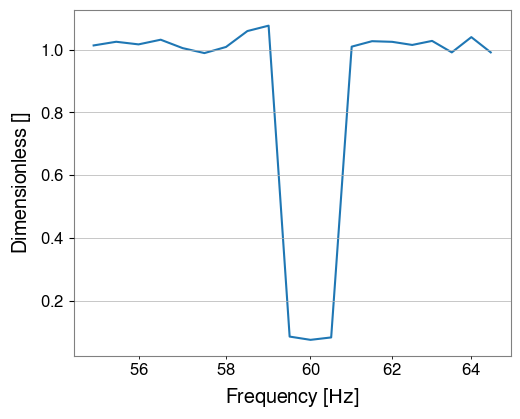

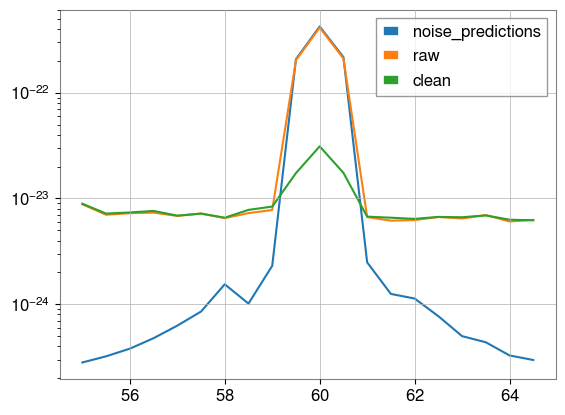

In [76]:
state = get_state()
predictions = []
for i, y_hat in enumerate(do_inference(offline_it())):
    frame = state.update(y_hat, i)
    if frame is not None:
        predictions.append(frame)
predictions = np.concatenate(predictions)
clean = y[:len(predictions)] - predictions
plot_predictions(clean, y)
plot_timeseries(
    noise_predictions=predictions,
    raw=y,
    clean=clean
)

## Offline loading, online cleaning
Ok, now let's do offline data loading with full online cleaning machinery. To do this, we'll need to monkeypatch a few utility methods.

In [77]:
import logging
import time
from contextlib import contextmanager
from unittest.mock import patch

from cleaner import writer as writer_utils


class Predictions:
    def __init__(self):
        self.value = []

    def write_patch(self):
        def patch(obj, _):
            key = f"{channels[0]}_DEEPCLEAN_CANARY"
            value = obj[key].value
            self.value.append(value)
        return patch

    def finalize(self):
        return np.concatenate(self.value)


def make_request_patch(_, __):
    return 2


def getmtime_patch(_):
    return time.time()


@contextmanager
def dummy(predictions):
    mod = "cleaner.writer"
    patch1 = patch(f"{mod}.TimeSeriesDict.write", new=predictions.write_patch())
    patch2 = patch(
        f"{mod}.ExportClient._make_request",
        new=make_request_patch
    )
    patch3 = patch(f"{mod}.os.path.getmtime", new=getmtime_patch)
    with patch1, patch2, patch3:
        yield


def get_monitor_and_writer(strain_it, level=logging.WARNING):
    utils = reload(writer_utils)
    monitor = utils.ASDRMonitor(
        buffer_length=8,
        freq_low=58,
        freq_high=62,
        fftlength=2
    )
    with dummy(predictions):
        writer = utils.Writer(
            Path("."),
            strain_generator=strain_it,
            monitor=monitor,
            export_endpoint="",
        )
        writer.logger.setLevel(level)
    return monitor, writer

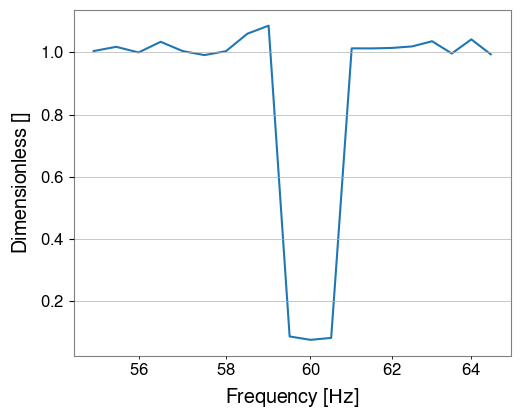

In [78]:
def strain_it():
    strains = np.split(y, test_duration)
    for i, frame in enumerate(strains):
        ts = TimeSeries(
            frame,
            sample_rate=sample_rate,
            channel=channels[0],
            t0=t0 + i
        )
        fname = f"{ifo}-llhoft-{test_start + i}-{1}.gwf"
        yield ts, Path(fname)


predictions = Predictions()
state = get_state()
monitor, writer = get_monitor_and_writer(strain_it())

for i, y_hat in enumerate(do_inference(offline_it())):
    frame = state.update(y_hat, i)
    if frame is not None:
        with dummy(predictions):
            writer(**{"deepclean-canary": frame})
predictions = predictions.finalize()
plot_predictions(predictions, y)

## Fully online
Finally, let's recreate the entire clean-time workflow in-memory

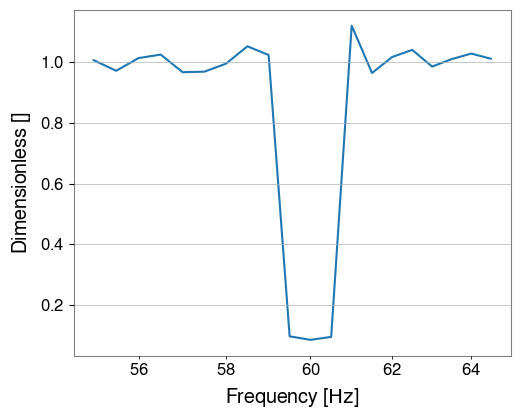

In [79]:
from cleaner.dataloader import get_data_generators

def online_it(witness_it, N=None):
    i = 0
    while True:
        if N is not None and i >= N:
            break
        try:
            yield next(witness_it)[0]
        except StopIteration:
            break
        i += 1

predictions = Predictions()
witness_it, strain_it = get_data_generators(
    run_dir / "live-data",
    ifo,
    channels,
    sample_rate=sample_rate,
    inference_sampling_rate=inference_sampling_rate,
    batch_size=infer_batch_size,
    t0=t0,
    timeout=0,
)

state = get_state()
monitor, writer = get_monitor_and_writer([])
it = online_it(witness_it, N=128)
strains = []
for i, y_hat in enumerate(do_inference(it)):
    frame = state.update(y_hat, i)
    if frame is not None:
        strain, fname = next(strain_it)
        strains.append(strain)
        writer.strain_generator = iter([(strain, fname)])
        with dummy(predictions):
            writer(**{"deepclean-canary": frame})
predictions = predictions.finalize()
strains = np.concatenate([i.value for i in strains])
plot_predictions(predictions, strains)